In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warehouse_env as wh
from td_control_agent import TDControl_Agent, DQN_Agent, state_to_tensor, evaluate_success_rate, watch_agent_perform
from plot_utils import plot_steps_rewards, plot_qvalues_slice, plot_policy_slice, plot_success_rate, plot_deltaQ
import matplotlib.pyplot as plt
import time
import numpy as np
import os
import torch
import random

SEED = 64

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [22]:
N_EPISODES = 20000
ENV_ROWS = 8
ENV_COLS = 10
ENV_CRATES = 5
GAMMA = 0.99

# Q-Learning
LR_QL = 0.2
EPSILON_0 = 0.2
TSTAR = 10000

# DQN
LR_DQN = 0.001
EPSILON_START = 0.9
EPSILON_END   = 0.05
EPSILON_DECAY = 0.999
BUFFER_SIZE = 10000
BATCH_SIZE = 128
TARGET_UPDATE_FREQUENCY = 10 # Target network episode number update

In [4]:
env_ql = wh.WarehouseEnv(rows=ENV_ROWS, cols=ENV_COLS, num_crates=ENV_CRATES, reward=20)
QL = TDControl_Agent(action_size=4, gamma=GAMMA, lr=LR_QL)

reward_trajectory_QL = np.zeros(N_EPISODES)       # hopefully higher as episodes increase
steps_per_episode_QL = np.zeros(N_EPISODES)       # hopefully lower as episodes increase 

count = 0
epsilon = EPSILON_0

for i in range(N_EPISODES):
    done = False
    steps = 0

    s, _ = env_ql.reset()
    a = QL.get_action_epsilon_greedy(s, epsilon)     # 0, 1, 2, 3
    
    while not done:

        count +=1
        steps +=1
        # Evolve one step
        new_s, r, terminated, truncated, _ = env_ql.step(a)
        done = terminated or truncated
        
        # Keeps track of performance for each episode
        reward_trajectory_QL[i] += r
        
        # Choose new action index
        new_a = QL.get_action_epsilon_greedy(new_s, epsilon)

### Change this function if you want either SARSA or Q-Learning ----------------------------
        _ = QL.single_step_update_QL(s, a, r, new_s, done)
### ----------------------------------------------------------------------------------------

        if count > TSTAR:
            QL.alpha = LR_QL / (1 + 0.003*(count - TSTAR)**0.75)
            epsilon = EPSILON_0 / (1. + 0.005*(count - TSTAR)**1.05)
        
        a = new_a
        s = new_s
        
    steps_per_episode_QL[i] += steps

Qvalues = QL.Qvalues
print(f"\nTotal time steps: {count}")
print(f"\nTotal theoretical states: {len(env_ql)}")
print(f"Visited states: {len(Qvalues)}")


Total time steps: 113680

Total theoretical states: 41400
Visited states: 5110


In [ ]:
env_dqn = wh.WarehouseEnv(rows=ENV_ROWS, cols=ENV_COLS, num_crates=ENV_CRATES, reward=20)
print(len(env_dqn))
DQN = DQN_Agent(env_dqn, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, LR_DQN, BUFFER_SIZE, BATCH_SIZE, device=device)

reward_trajectory_DQN = np.zeros(N_EPISODES)       # hopefully higher as episodes increase
steps_per_episode_DQN = np.zeros(N_EPISODES)       # hopefully lower as episodes increase 

for i in range(N_EPISODES):
    done = False
    steps = 0
    
    s, _ = env_dqn.reset()
    
    while not done:

        steps += 1
        s_tensor = state_to_tensor(s, env_dqn).to(DQN.device)
        a_tensor = DQN.select_action(s_tensor)
        a = a_tensor.item()
        
        new_s, r, terminated, truncated, _ = env_dqn.step(a)
        done = terminated or truncated

        reward_trajectory_DQN[i] += r
        
        # Convert non-tensor quantities to tensors, to store in experience buffer
        r_tensor = torch.tensor([r], device=DQN.device)
        done_tensor = torch.tensor([done], device=DQN.device, dtype=torch.float32)
        new_s_tensor = state_to_tensor(new_s, env_dqn).to(DQN.device)
        
        # Buffer update
        DQN.buffer.push(s_tensor, a_tensor, r_tensor, new_s_tensor, done_tensor)
        
        s = new_s
        
        # Execute a learning step
        DQN.learn()

    steps_per_episode_DQN[i] += steps
    #if i == 0 or (i+1) % 100 == 0:
    print(f"Episode {i+1}/{N_EPISODES}")
    
    if (i+1) % TARGET_UPDATE_FREQUENCY == 0:
        DQN.update_target_net()

14424009600
Episode 1/20000
Episode 2/20000
Episode 3/20000
Episode 4/20000
Episode 5/20000
Episode 6/20000
Episode 7/20000
Episode 8/20000
Episode 9/20000
Episode 10/20000
Episode 11/20000
Episode 12/20000
Episode 13/20000
Episode 14/20000
Episode 15/20000
Episode 16/20000
Episode 17/20000
Episode 18/20000
Episode 19/20000
Episode 20/20000
Episode 21/20000
Episode 22/20000
Episode 23/20000
Episode 24/20000
Episode 25/20000
Episode 26/20000
Episode 27/20000
Episode 28/20000
Episode 29/20000
Episode 30/20000
Episode 31/20000
Episode 32/20000
Episode 33/20000
Episode 34/20000
Episode 35/20000
Episode 36/20000
Episode 37/20000
Episode 38/20000
Episode 39/20000
Episode 40/20000
Episode 41/20000
Episode 42/20000
Episode 43/20000
Episode 44/20000
Episode 45/20000
Episode 46/20000
Episode 47/20000
Episode 48/20000


In [11]:
final_success_rate_QL = evaluate_success_rate(QL, env_ql, num_test_episodes=250,max_steps_per_episode=100)
final_success_rate_DQN = evaluate_success_rate(DQN, env_dqn, num_test_episodes=250,max_steps_per_episode=100)

print(f"Success rate of Q-Learning Agent: {final_success_rate_QL:.2f}%")
print(f"Success rate of DQN Agent: {final_success_rate_DQN:.2f}%")

Success rate of Q-Learning Agent: 71.20%
Success rate of DQN Agent: 100.00%


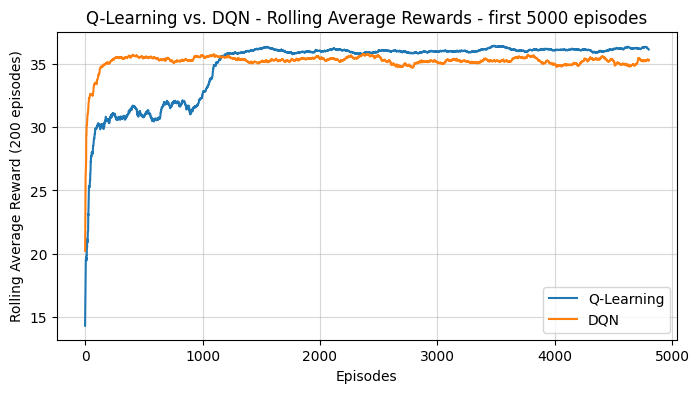

In [14]:
plt.figure(figsize=(8, 4))

window = 200
rolling_avg_ql = np.convolve(reward_trajectory_QL[:5000], np.ones(window)/window, mode='valid')
rolling_avg_dqn = np.convolve(reward_trajectory_DQN[:5000], np.ones(window)/window, mode='valid')

plt.plot(rolling_avg_ql, label='Q-Learning', color='C0')
plt.plot(rolling_avg_dqn, label='DQN', color='C1')

plt.title(f"Q-Learning vs. DQN - Rolling Average Rewards - first 5000 episodes")
plt.xlabel("Episodes")
plt.ylabel("Rolling Average Reward (200 episodes)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

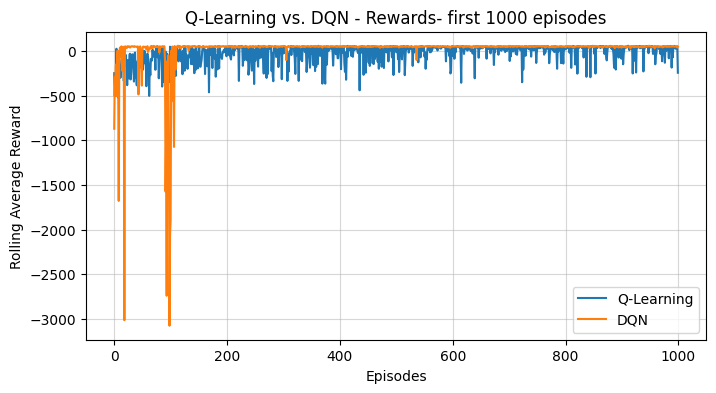

In [8]:
plt.figure(figsize=(8, 4))

window = 200
rolling_avg_ql = np.convolve(reward_trajectory_QL[:1000], np.ones(window)/window, mode='valid')
rolling_avg_dqn = np.convolve(reward_trajectory_DQN[:1000], np.ones(window)/window, mode='valid')

plt.plot(reward_trajectory_QL[:1000], label='Q-Learning', color='C0')
plt.plot(reward_trajectory_DQN[:1000], label='DQN', color='C1')

plt.title(f"Q-Learning vs. DQN - Rewards- first 1000 episodes")
plt.xlabel("Episodes")
plt.ylabel("Rolling Average Reward")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

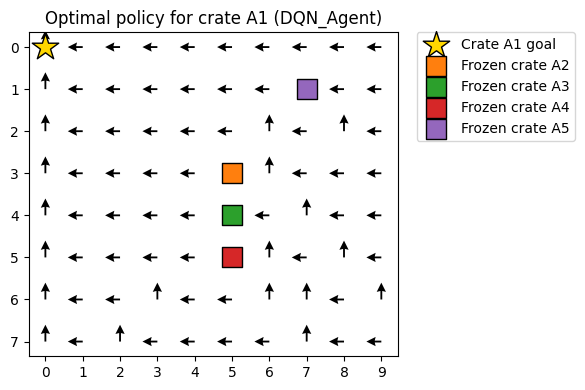

In [21]:
fixed_context = { "active_id": 0, "fixed_positions": {1: (3, 5), 2: (4, 5), 3: (5, 5), 4: (1, 7)} }
#plot_policy_slice(QL, env_ql, fixed_context)
plot_policy_slice(DQN, env_dqn, fixed_context)

In [5]:
watch_agent_perform(QL, env_ql)

 X   .   .   .   . 
 X   .   .   .   . 
 X   .   .   .   . 
 .   .   .   .   . 
 .   .   .   .   . 


Success. The agent sorted the crates in 14 steps.

Total reward: 49


In [15]:
watch_agent_perform(DQN, env_dqn)

 X   .   .   .   .   .   .   .   .   . 
 X   .   .   .   .   .   .   .   .   . 
 X   .   .   .   .   .   .   .   .   . 
 X   .   .   .   .   .   .   .   .   . 
 X   .   .   .   .   .   .   .   .   . 
 .   .   .   .   .   .   .   .   .   . 
 .   .   .   .   .   .   .   .   .   . 
 .   .   .   .   .   .   .   .   .   . 


Success. The agent sorted the crates in 34 steps.

Total reward: 71


In [23]:
n_episodes = 60000
tstar = 20000
Epsilons_0 = [0.15]
LRs_0 = [0.20]
Gamma = [0.99]

example_fixed_state = {
    "active_id": 0,
    "fixed_positions": {
        1: (4, 1),
        2: (2, 3)
    }
}

# Initialize
for epsilon_0 in Epsilons_0:
    for lr_0 in LRs_0:
        for gamma in Gamma:

            # -----------------------------------------------------------------------------------
            # Variables and parameters used for tests and logging
            # 1. Every 2000 episodes, test the agent for 100 episodes of max 100 steps each, and record the success rate
            count = 0
            success_rate_trajectory = []
            test_indexes = []

            # 2. Record the absolute value of deltaQ to track convergence
            avg_absDeltaQ = []
            max_absDeltaQ = []

            # 3. Reward and Steps trajectories
            reward_trajectory = np.zeros(n_episodes)       # hopefully higher as episodes increase
            steps_per_episode = np.zeros(n_episodes)       # hopefully lower as episodes increase 
            # -----------------------------------------------------------------------------------

            env = wh.WarehouseEnv(rows=5, cols=5, num_crates=3, reward=20)

            # Visualize a sample starting state
            s, _ = env.reset()
            print("Starting state (sample):\n")
            print(f"{s}\n")
            env.render()

            AGENT = TDControl_Agent(action_size=4, gamma=gamma, lr=lr_0)

            epsilon = epsilon_0

            for i in range(n_episodes):
                done = False
                absDeltaQ = []     # Absolute value of deltaQ to track convergence
                steps = 0

                # Test mode every 2000 episodes
                if i%2000 == 0 or i==n_episodes-1:
                    rate = evaluate_success_rate(AGENT, env, num_test_episodes=100, max_steps_per_episode=100)
                    success_rate_trajectory.append(rate)
                    test_indexes.append(i+1)

                s, _ = env.reset()
                a = AGENT.get_action_epsilon_greedy(s, epsilon)     # 0, 1, 2, 3
                
                while not done:

                    count +=1
                    steps +=1
                    # Evolve one step
                    new_s, r, terminated, truncated, _ = env.step(a)
                    done = terminated or truncated
                    
                    # Keeps track of performance for each episode
                    reward_trajectory[i] += r
                    
                    # Choose new action index
                    new_a = AGENT.get_action_epsilon_greedy(new_s, epsilon)

### Change this function if you want either SARSA or Q-Learning ----------------------------
                    deltaQ = AGENT.single_step_update_QL(s, a, r, new_s, done)
### ----------------------------------------------------------------------------------------

                    absDeltaQ.append(deltaQ)

                    if count > tstar:
                        AGENT.alpha = lr_0 / (1 + 0.003*(count - tstar)**0.75)
                        epsilon = epsilon_0 / (1. + 0.005*(count - tstar)**1.05)
                    
                    a = new_a
                    s = new_s
                    
                avg_absDeltaQ.append(sum(absDeltaQ)/len(absDeltaQ))
                max_absDeltaQ.append(max(absDeltaQ))
                steps_per_episode[i] += steps

                #if i%100 == 0 or i==n_episodes-1:
                #    print(f"Episode: {i}, Epsilon: {epsilon}")
            
            eps0_alias = format(epsilon_0, ".2f")[2:]
            lr0_alias = format(lr_0, ".2f")[2:]
            gam_alias = format(gamma, ".2f")[2:]
            config_folder = "results/eps" + eps0_alias + "/lr" + lr0_alias + "/gam" + gam_alias + "/"
            # --> e.g., for epsilon_0=0.20, lr_0=0.12, gamma=0.99:   config_folder == "eps20/lr12/gam99/"

            os.makedirs(config_folder, exist_ok=True)

            #plot_steps_rewards(n_episodes, reward_trajectory, display_mode="reward", save_path=config_folder + "reward.png")
            #plot_steps_rewards(n_episodes, steps_per_episode, display_mode="steps", save_path=config_folder + "steps.png")
            #plot_qvalues_slice(AGENT, env, example_fixed_state, save_path=config_folder + "qvalues.png")
            #plot_policy_slice(AGENT, env, example_fixed_state, save_path=config_folder + "policy.png")
            #plot_success_rate(test_indexes, success_rate_trajectory, save_path=config_folder + "success_rate.png")
            #plot_deltaQ(n_episodes, avg_absDeltaQ, max_absDeltaQ, save_path=config_folder + "deltaQ.png")

            print("Ending state (final episode):\n")
            env.render()

            Qvalues = AGENT.Qvalues
            print(f"\nTotal time steps: {count}")
            print(f"\nTotal theoretical states: {len(env)}")
            print(f"Visited states: {len(Qvalues)}")


Starting state (sample):

{'active_crate_id': np.int32(0), 'crate_positions': array([[0, 3],
       [1, 2],
       [4, 4]], dtype=int32)}

[G]  .   .   A1  . 
 G   .   a2  .   . 
 G   .   .   .   . 
 .   .   .   .   . 
 .   .   .   .   a3

Ending state (final episode):

 X   .   .   .   . 
 X   .   .   .   . 
 X   .   .   .   . 
 .   .   .   .   . 
 .   .   .   .   . 


Total time steps: 780030

Total theoretical states: 41400
Visited states: 5460


In [5]:
print(type((np.zeros(4))))

<class 'numpy.ndarray'>


In [ ]:
'''
env = wh.WarehouseEnv(rows=5, cols=5, num_crates=3, reward=50)
print(f"State space size: {len(env)}\n")

s, _ = env.reset()
print(s)

done = False

print("Starting State:")
while not done:
    env.render()
    action = env.action_space.sample()      # random agent
    s, reward, terminated, truncated, _ = env.step(action)
    print(s)
    done = terminated or truncated
    
    time.sleep(1)
    print(f"Action: {moves_map[action]}, Reward: {reward}, Done: {done}")'''

In [ ]:
'''
import math

C = 3
N = 5
M = 5

print(C * math.perm(N*M, C))

print(C * N*M * ( math.factorial((N*M)-1) / math.factorial((N*M)-C ) ))
'''

'\nimport math\n\nC = 3\nN = 5\nM = 5\n\nprint(C * math.perm(N*M, C))\n\nprint(C * N*M * ( math.factorial((N*M)-1) / math.factorial((N*M)-C ) ))\n'

In [ ]:
'''
from collections import defaultdict

mydict = defaultdict(lambda: np.zeros(4))
print(mydict)

mydict["A"][0] = 10
print(mydict) 

print(mydict["B"])  # printing mydict["B"] (which doesn't exist) creates a "B" element with default value 0,0,0,0

print(mydict)
'''

'\nfrom collections import defaultdict\n\nmydict = defaultdict(lambda: np.zeros(4))\nprint(mydict)\n\nmydict["A"][0] = 10\nprint(mydict) \n\nprint(mydict["B"])  # printing mydict["B"] (which doesn\'t exist) creates a "B" element with default value 0,0,0,0\n\nprint(mydict)\n'

In [ ]:
"""rows=5
cols=5
env = wh.WarehouseEnv(rows=5, cols=5, num_crates=3, reward=20)

# Visualize a sample starting state
s, _ = env.reset()
print("Starting state (sample):\n")
print(f"{s}\n")

active_id = s['active_crate_id']
active_pos = s['crate_positions'][active_id]

print(active_id)
print(active_pos)

tensor = torch.zeros((4, rows, cols))
tensor[0, active_pos[0], active_pos[1]] = 1
print(tensor)

print(torch.zeros(4))"""